In [1]:
from xmip.utils import google_cmip_col
from xmip.preprocessing import combined_preprocessing
from xmip.postprocessing import concat_experiments, pick_first_member, _drop_duplicate_grid_labels #TODO:  _drop_duplicate_grid_labels should be public?

In [2]:
col = google_cmip_col()
col

,unique
activity_id,18
institution_id,36
source_id,88
experiment_id,170
member_id,657
table_id,37
variable_id,700
grid_label,10
zstore,514818
dcpp_init_year,60


In [3]:
source_ids = [s for s in sorted(col.df['source_id'].unique()) if s not in ['AWI-CM-1-1-MR','AWI-ESM-1-1-LR']]

In [4]:
cat = col.search(
    variable_id='tos', 
    experiment_id=['historical', 'ssp245'], 
    table_id='Omon', 
    source_id=source_ids, 
    require_all_on=['source_id', 'grid_label', 'member_id']
)
cat

In [6]:
# Loading all these datasets into xarray takes long, but not prohibitively long (few minutes). 
# As a more perfomant option one could work some pandas magic and select members based on availability of both experiments, and filter out grid_labels.
# For this purpose Ill take the slightly longer loading time.

# Could look something like this:
# def prune_members(df):
#     return df.iloc[0]

# df = cat.df
# pruned_df = df.groupby([c for c in df.columns if c not in ['member_id', 'zstore', 'dcpp_init_year']], group_keys=False, as_index=False).apply(prune_members)
# cat.esmcat._df = pruned_df
# cat

ddict = cat.to_dataset_dict(aggregate=False, preprocess=combined_preprocessing)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


/srv/conda/envs/notebook/lib/python3.10/site-packages/xmip/preprocessing.py:96: UserWarning: CMIP.MIROC.MIROC-ES2L.historical.r22i1p1f2.Omon.gn.none.tos:While renaming to target `lon_bounds`, more than one candidate was found ['x_bnds', 'vertices_longitude']. Renaming x_bnds to lon_bounds. Please double check results.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.10/site-packages/xmip/preprocessing.py:96: UserWarning: CMIP.MIROC.MIROC-ES2L.historical.r22i1p1f2.Omon.gn.none.tos:While renaming to target `lat_bounds`, more than one candidate was found ['y_bnds', 'vertices_latitude']. Renaming y_bnds to lat_bounds. Please double check results.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.10/site-packages/xmip/preprocessing.py:96: UserWarning: ScenarioMIP.MIROC.MIROC-ES2L.ssp245.r3i1p1f2.Omon.gn.none.tos:While renaming to target `lon_bounds`, more than one candidate was found ['x_bnds', 'vertices_longitude']. Renaming x_bnds to lon_bounds. Please double check results.
  war

In [7]:
ddict_concat = concat_experiments(ddict)

In [8]:
ddict_pruned = _drop_duplicate_grid_labels(pick_first_member(ddict_concat), 'gr')

/srv/conda/envs/notebook/lib/python3.10/site-packages/xmip/postprocessing.py:89: UserWarning: Match attributes ['experiment_id'] not found in any of the datasets.         This can happen when several combination functions are used and attributes are removed during merging.         Double check the results.
  warnings.warn(


In [9]:
sorted(list(ddict_pruned.keys()))

['ACCESS-CM2.Omon.r1i1p1f1.tos.tos',
 'BCC-CSM2-MR.Omon.r1i1p1f1.tos.tos',
 'CAMS-CSM1-0.Omon.r1i1p1f1.tos.tos',
 'CESM2-WACCM.Omon.r1i1p1f1.tos.tos',
 'CESM2.Omon.r10i1p1f1.tos.tos',
 'CIESM.Omon.r1i1p1f1.tos.tos',
 'CMCC-CM2-SR5.Omon.r1i1p1f1.tos.tos',
 'CMCC-ESM2.Omon.r1i1p1f1.tos.tos',
 'CNRM-CM6-1-HR.Omon.r1i1p1f2.tos.tos',
 'CNRM-CM6-1.Omon.r10i1p1f2.tos.tos',
 'CNRM-ESM2-1.Omon.r10i1p1f2.tos.tos',
 'CanESM5-CanOE.Omon.r1i1p2f1.tos.tos',
 'CanESM5.Omon.r10i1p1f1.tos.tos',
 'EC-Earth3-CC.Omon.r1i1p1f1.tos.tos',
 'EC-Earth3-Veg-LR.Omon.r1i1p1f1.tos.tos',
 'EC-Earth3-Veg.Omon.r2i1p1f1.tos.tos',
 'EC-Earth3.Omon.r101i1p1f1.tos.tos',
 'EC-Earth3.Omon.r10i1p1f1.tos.tos',
 'FGOALS-f3-L.Omon.r1i1p1f1.tos.tos',
 'FGOALS-g3.Omon.r1i1p1f1.tos.tos',
 'FIO-ESM-2-0.Omon.r1i1p1f1.tos.tos',
 'GFDL-CM4.Omon.r1i1p1f1.tos.tos',
 'GFDL-ESM4.Omon.r1i1p1f1.tos.tos',
 'GISS-E2-1-G.Omon.r10i1p1f2.tos.tos',
 'HadGEM3-GC31-LL.Omon.r1i1p1f3.tos.tos',
 'IITM-ESM.Omon.r1i1p1f1.tos.tos',
 'INM-CM4-8.Omon.r1i1

In [10]:
# Cut to the time frame desired (1990-2019)
ddict_time_selected = {k:ds.sel(time=slice('1990', '2019')) for k,ds in ddict_pruned.items()}
# make sure all the datasets have the same length in time
assert len(set([len(ds.time) for ds in ddict_time_selected.values()])) == 1

In [11]:
from distributed import Client
client = Client()

In [12]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/jbusecke/proxy/8787/status,
Dashboard: /user/jbusecke/proxy/8787/status,Workers: 4
Total threads: 16,Total memory: 125.81 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40371,Workers: 4
Dashboard: /user/jbusecke/proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 125.81 GiB
Comm: tcp://127.0.0.1:46661,Total threads: 4
Dashboard: /user/jbusecke/proxy/45069/status,Memory: 31.45 GiB
Nanny: tcp://127.0.0.1:35785,


In [13]:
sizes = [ds.nbytes/1e9 for ds in ddict_time_selected.values()]
sizes

[0.16519016,
 0.16519016,
 0.162601384,
 0.164066496,
 0.162601384,
 0.190724048,
 0.107725136,
 0.100582576,
 0.164066496,
 1.203991824,
 0.020124448,
 0.100582576,
 0.11428016,
 0.352874432,
 0.177738976,
 0.087421104,
 0.164066496,
 2.265675024,
 0.104269136,
 0.203438544,
 0.177738976,
 1.771789136,
 0.50287872,
 0.184825808,
 0.167629936,
 0.164066496,
 0.190724048,
 0.215121816,
 0.11428016,
 0.100582576,
 2.265122192,
 0.164066496,
 0.100582576,
 0.100582576,
 0.164066496,
 0.215121816,
 0.130304592,
 0.190724048,
 0.158147072,
 0.100582576,
 0.023849552]

In [14]:
# load all datasets into memory to speed this up
from tqdm.auto import tqdm

ddict_loaded = {}
for k, ds in tqdm(ddict_time_selected.items()):
    print(k)
    ddict_loaded[k] = ds.load()

  0%|          | 0/41 [00:00<?, ?it/s]

CNRM-CM6-1.Omon.r10i1p1f2.tos.tos
CNRM-ESM2-1.Omon.r10i1p1f2.tos.tos
CanESM5-CanOE.Omon.r1i1p2f1.tos.tos
EC-Earth3.Omon.r101i1p1f1.tos.tos
CanESM5.Omon.r10i1p1f1.tos.tos
CIESM.Omon.r1i1p1f1.tos.tos
CAMS-CSM1-0.Omon.r1i1p1f1.tos.tos
GFDL-ESM4.Omon.r1i1p1f1.tos.tos
CMCC-CM2-SR5.Omon.r1i1p1f1.tos.tos
MIROC-ES2L.Omon.r10i1p1f2.tos.tos
GISS-E2-1-G.Omon.r10i1p1f2.tos.tos
CESM2-WACCM.Omon.r1i1p1f1.tos.tos
FGOALS-g3.Omon.r1i1p1f1.tos.tos
IPSL-CM6A-LR.Omon.r10i1p1f1.tos.tos
UKESM1-0-LL.Omon.r1i1p1f2.tos.tos
MPI-ESM1-2-LR.Omon.r10i1p1f1.tos.tos
EC-Earth3-Veg-LR.Omon.r1i1p1f1.tos.tos
MIROC6.Omon.r10i1p1f1.tos.tos
IITM-ESM.Omon.r1i1p1f1.tos.tos
EC-Earth3.Omon.r10i1p1f1.tos.tos
HadGEM3-GC31-LL.Omon.r1i1p1f3.tos.tos
KACE-1-0-G.Omon.r1i1p1f1.tos.tos
MPI-ESM1-2-HR.Omon.r1i1p1f1.tos.tos
CESM2.Omon.r10i1p1f1.tos.tos
ACCESS-CM2.Omon.r1i1p1f1.tos.tos
EC-Earth3-Veg.Omon.r2i1p1f1.tos.tos
FIO-ESM-2-0.Omon.r1i1p1f1.tos.tos
NorESM2-LM.Omon.r1i1p1f1.tos.tos
FGOALS-f3-L.Omon.r1i1p1f1.tos.tos
MRI-ESM2-0.Omon.r1i1

In [19]:
ds = ddict_loaded['CESM2.Omon.r10i1p1f1.tos.tos']
ds

<xarray.Dataset>
Dimensions:         (member_id: 1, dcpp_init_year: 1, time: 360, y: 384,
                     x: 320, vertex: 4, bnds: 2)
Coordinates:
    lat             (y, x) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
    lon             (y, x) float64 320.6 321.7 322.8 323.9 ... 318.9 319.4 319.8
  * time            (time) object 1990-01-15 12:00:00 ... 2019-12-15 12:00:00
    lon_verticies   (y, x, vertex) float32 320.0 320.0 321.1 ... 320.0 320.0
    lat_verticies   (y, x, vertex) float32 -79.49 -78.95 -78.95 ... 72.41 71.96
    time_bounds     (time, bnds) object 1990-01-01 00:00:00 ... 2020-01-01 00...
  * y               (y) int64 0 1 2 3 4 5 6 7 ... 377 378 379 380 381 382 383
  * x               (x) int64 0 1 2 3 4 5 6 7 ... 313 314 315 316 317 318 319
    lon_bounds      (bnds, y, x) float32 320.0 321.1 322.2 ... 319.1 319.6 320.0
    lat_bounds      (bnds, y, x) float32 -79.49 -79.49 -79.49 ... 72.42 72.41
  * member_id       (member_id) object 'r10i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 nan
Dimensions without coordinates: vertex, bnds
Data variables:
    tos             (member_id, dcpp_init_year, time, y, x) float32 nan ... nan
Attributes: (12/41)
    Conventions:                      CF-1.7 CMIP-6.2
    branch_method:                    standard
    contact:                          cesm_cmip6@ucar.edu
    external_variables:               areacello
    forcing_index:                    1
    frequency:                        mon
    ...                               ...
    intake_esm_attrs:table_id:        Omon
    intake_esm_attrs:variable_id:     tos
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:_data_format_:   zarr
    creation_date:                    2020-05-26T19:18:20Z
    original_key:                     ScenarioMIP.NCAR.CESM2.ssp245.r10i1p1f1...

In [20]:
# compute the linear trend
import xarray as xr

def calculate_linear_trend(ds):
    da = ds.tos.squeeze().load()
    coeffs = da.polyfit('time', 1)
    # evaluate trend coefficients
    trend = xr.polyval(ds.time, coeffs.polyfit_coefficients)
    # compute the linear trend difference between beginning and end
    diff = trend.isel(time=[0,-1]).diff('time').squeeze()
    diff = diff.assign_coords({k:ds[k] for k in ['lon', 'lat']})
    return diff

# ddict_trends = {}
# for k, ds in tqdm(ddict_time_selected.items()):
#     print(k)
#     ddict_trends[k] = calculate_linear_trend(ds)

ddict_trends = {}
for k, ds in ddict_loaded.items():
    print(k)
    ddict_trends[k] = calculate_linear_trend(ds)

CNRM-CM6-1.Omon.r10i1p1f2.tos.tos
CNRM-ESM2-1.Omon.r10i1p1f2.tos.tos
CanESM5-CanOE.Omon.r1i1p2f1.tos.tos
EC-Earth3.Omon.r101i1p1f1.tos.tos
CanESM5.Omon.r10i1p1f1.tos.tos
CIESM.Omon.r1i1p1f1.tos.tos
CAMS-CSM1-0.Omon.r1i1p1f1.tos.tos
GFDL-ESM4.Omon.r1i1p1f1.tos.tos
CMCC-CM2-SR5.Omon.r1i1p1f1.tos.tos
MIROC-ES2L.Omon.r10i1p1f2.tos.tos
GISS-E2-1-G.Omon.r10i1p1f2.tos.tos
CESM2-WACCM.Omon.r1i1p1f1.tos.tos
FGOALS-g3.Omon.r1i1p1f1.tos.tos
IPSL-CM6A-LR.Omon.r10i1p1f1.tos.tos
UKESM1-0-LL.Omon.r1i1p1f2.tos.tos
MPI-ESM1-2-LR.Omon.r10i1p1f1.tos.tos
EC-Earth3-Veg-LR.Omon.r1i1p1f1.tos.tos
MIROC6.Omon.r10i1p1f1.tos.tos
IITM-ESM.Omon.r1i1p1f1.tos.tos
EC-Earth3.Omon.r10i1p1f1.tos.tos
HadGEM3-GC31-LL.Omon.r1i1p1f3.tos.tos
KACE-1-0-G.Omon.r1i1p1f1.tos.tos
MPI-ESM1-2-HR.Omon.r1i1p1f1.tos.tos
CESM2.Omon.r10i1p1f1.tos.tos
ACCESS-CM2.Omon.r1i1p1f1.tos.tos
EC-Earth3-Veg.Omon.r2i1p1f1.tos.tos
FIO-ESM-2-0.Omon.r1i1p1f1.tos.tos
NorESM2-LM.Omon.r1i1p1f1.tos.tos
FGOALS-f3-L.Omon.r1i1p1f1.tos.tos
MRI-ESM2-0.Omon.r1i1

In [23]:
ddict_trends['CESM2.Omon.r10i1p1f1.tos.tos']

<xarray.DataArray (y: 384, x: 320)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [0.02529366, 0.02627878, 0.02687593, ...,        nan,        nan,
               nan],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]])
Coordinates:
    time     object 2019-12-15 12:00:00
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 375 376 377 378 379 380 381 382 383
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 311 312 313 314 315 316 317 318 319
    lat      (y, x) float64 -79.22 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
    lon      (y, x) float64 320.6 321.7 322.8 323.9 ... 318.5 318.9 319.4 319.8

In [24]:
# Last step: Interpolate the trend maps on a commmon grid
# NOTE: I could have done this before, and then taken the linear trend, but this should be a lot more efficient.
import xesmf as xe

In [47]:
# there is a double entry for EC-Earth
# TODO: investigate why
# for now quick fix
ddict_trends_new = {k:ds for k,ds in ddict_trends.items() if k not in ['EC-Earth3.Omon.r101i1p1f1.tos.tos']}

In [61]:
target_grid = xe.util.grid_global(1, 1) # interpolate on regular 1 deg grid. 
# Might want to put this to a higher res as some models have higher native resolution
# and we might be aliasing.
# But should be ok for a first take
datasets = []
for model, ds in ddict_trends_new.items():
    print(model)
    # make sure only lon/lat have values
    ds = ds.drop(['x', 'y'])
    regridder = xe.Regridder(
        ds,
        target_grid,
        method='bilinear',
        periodic=True,
        ignore_degenerate=True, 
        unmapped_to_nan=True
    )
    ds_regridded = regridder(ds).assign_coords(model=model.split('.')[0])
    datasets.append(ds_regridded)

CNRM-CM6-1.Omon.r10i1p1f2.tos.tos
CNRM-ESM2-1.Omon.r10i1p1f2.tos.tos
CanESM5-CanOE.Omon.r1i1p2f1.tos.tos
CanESM5.Omon.r10i1p1f1.tos.tos
CIESM.Omon.r1i1p1f1.tos.tos
CAMS-CSM1-0.Omon.r1i1p1f1.tos.tos
GFDL-ESM4.Omon.r1i1p1f1.tos.tos


/srv/conda/envs/notebook/lib/python3.10/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


CMCC-CM2-SR5.Omon.r1i1p1f1.tos.tos
MIROC-ES2L.Omon.r10i1p1f2.tos.tos
GISS-E2-1-G.Omon.r10i1p1f2.tos.tos
CESM2-WACCM.Omon.r1i1p1f1.tos.tos
FGOALS-g3.Omon.r1i1p1f1.tos.tos
IPSL-CM6A-LR.Omon.r10i1p1f1.tos.tos
UKESM1-0-LL.Omon.r1i1p1f2.tos.tos
MPI-ESM1-2-LR.Omon.r10i1p1f1.tos.tos
EC-Earth3-Veg-LR.Omon.r1i1p1f1.tos.tos
MIROC6.Omon.r10i1p1f1.tos.tos
IITM-ESM.Omon.r1i1p1f1.tos.tos
EC-Earth3.Omon.r10i1p1f1.tos.tos
HadGEM3-GC31-LL.Omon.r1i1p1f3.tos.tos
KACE-1-0-G.Omon.r1i1p1f1.tos.tos
MPI-ESM1-2-HR.Omon.r1i1p1f1.tos.tos
CESM2.Omon.r10i1p1f1.tos.tos
ACCESS-CM2.Omon.r1i1p1f1.tos.tos
EC-Earth3-Veg.Omon.r2i1p1f1.tos.tos
FIO-ESM-2-0.Omon.r1i1p1f1.tos.tos
NorESM2-LM.Omon.r1i1p1f1.tos.tos
FGOALS-f3-L.Omon.r1i1p1f1.tos.tos
MRI-ESM2-0.Omon.r1i1p1f1.tos.tos
CNRM-CM6-1-HR.Omon.r1i1p1f2.tos.tos
CMCC-ESM2.Omon.r1i1p1f1.tos.tos
INM-CM4-8.Omon.r1i1p1f1.tos.tos
GFDL-CM4.Omon.r1i1p1f1.tos.tos
EC-Earth3-CC.Omon.r1i1p1f1.tos.tos
NorESM2-MM.Omon.r1i1p1f1.tos.tos
BCC-CSM2-MR.Omon.r1i1p1f1.tos.tos
TaiESM1.Omon.r1i1p

In [62]:
ds_merged = xr.concat(datasets, dim='model')
ds_merged

<xarray.DataArray (model: 40, y: 180, x: 360)>
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [ 0.04703704,  0.0478031 ,  0.04856817, ...,  0.04473475,
          0.04550268,  0.04627018],
        [ 0.05422035,  0.05456155,  0.05490516, ...,  0.05320706,
          0.05354528,  0.05388159],
        [ 0.05521084,  0.05533525,  0.05549275, ...,  0.05484549,
          0.05496597,  0.05508775]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
...
        [ 0.03427328,  0.03441521,  0.03377514, ...,  0.03099   ,
          0.03394038,  0.03416482],
        [ 0.03371526,  0.03366819,  0.03359198, ...,  0.0211787 ,
          0.02779786,  0.03380487],
        [-0.00609641, -0.00607292, -0.00617925, ..., -0.01263588,
         -0.01110321, -0.00727539]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]])
Coordinates:
    time     (model) object 1576497600000000000 ... 2019-12-17 00:00:00
    lat      (y, x) float64 -89.5 -89.5 -89.5 -89.5 ... 89.5 89.5 89.5 89.5
    lon      (y, x) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * model    (model) <U16 'CNRM-CM6-1' 'CNRM-ESM2-1' ... 'MCM-UA-1-0'
Dimensions without coordinates: y, x
Attributes:
    regrid_method:  bilinear

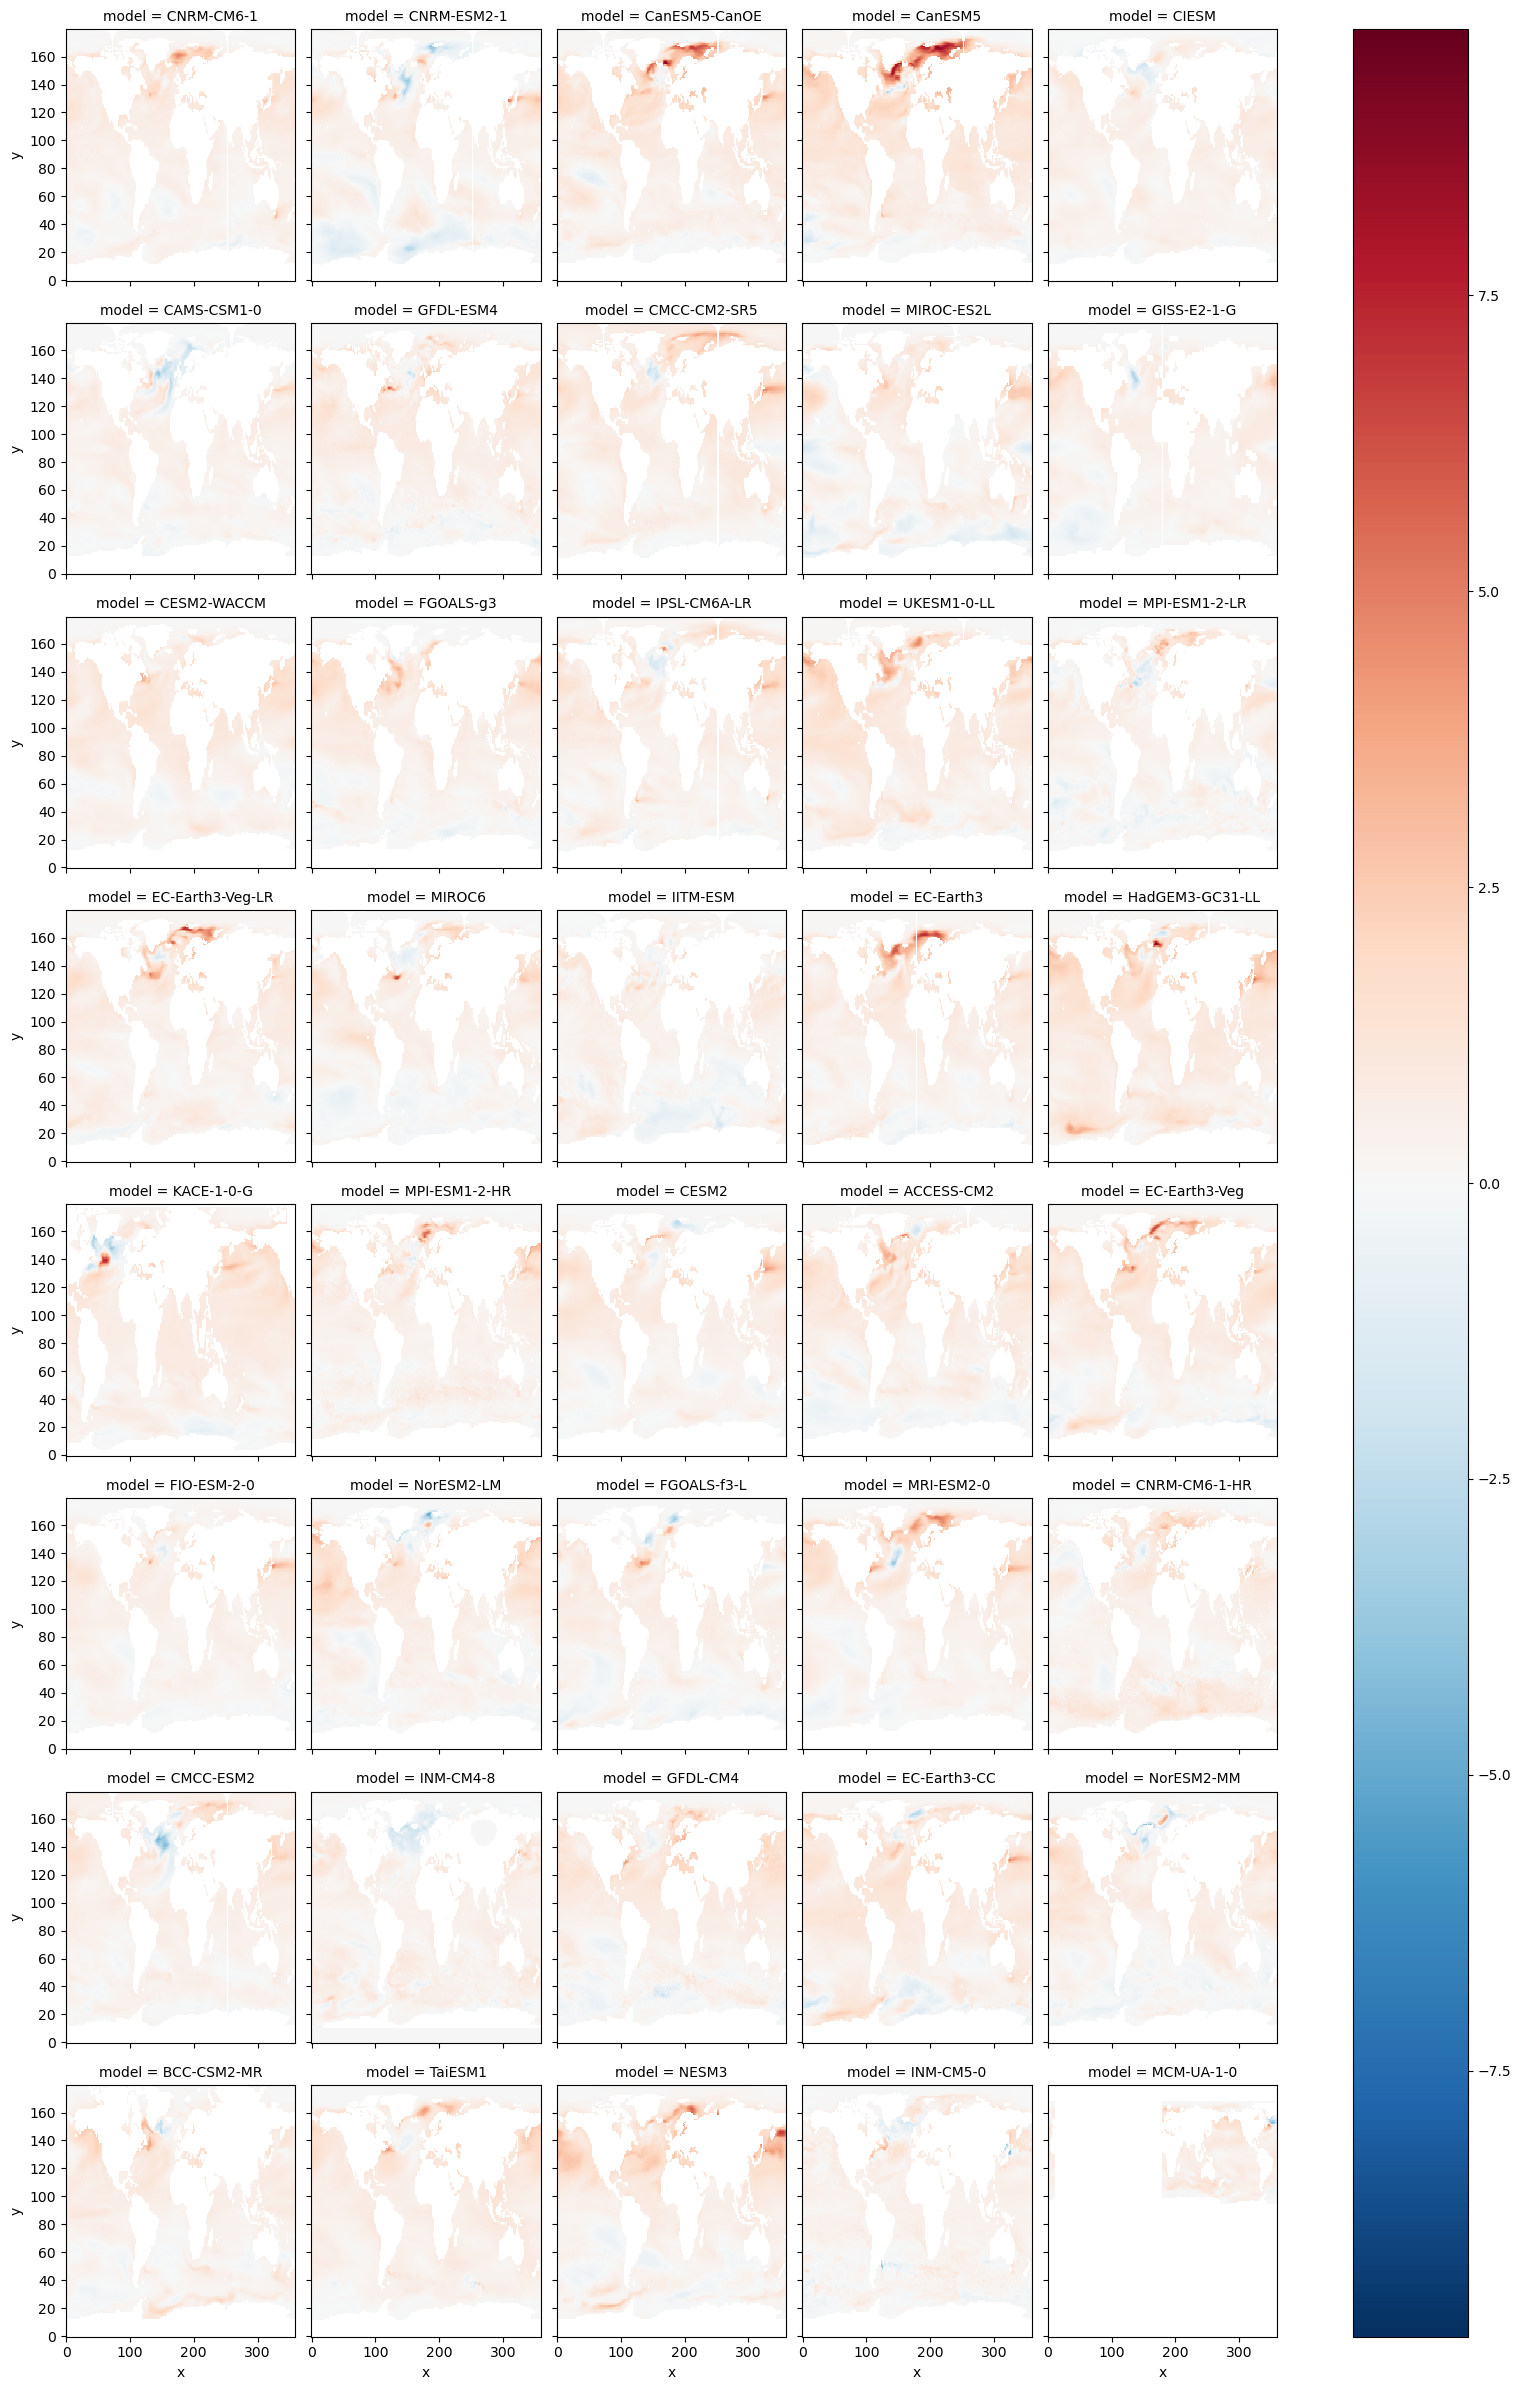

In [63]:
ds_merged.plot(col='model', col_wrap=5)

There are issues with two of the model. Just taking them out for now.

In [70]:
ds_merged_clean = ds_merged.sel(model = [m for m in ds_merged.model.data if m not in ['MCM-UA-1-0', 'KACE-1-0-G']])
ds_merged_clean

<xarray.DataArray (model: 38, y: 180, x: 360)>
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [ 0.04703704,  0.0478031 ,  0.04856817, ...,  0.04473475,
          0.04550268,  0.04627018],
        [ 0.05422035,  0.05456155,  0.05490516, ...,  0.05320706,
          0.05354528,  0.05388159],
        [ 0.05521084,  0.05533525,  0.05549275, ...,  0.05484549,
          0.05496597,  0.05508775]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
...
        [ 0.04927139,  0.04912429,  0.04895362, ...,  0.04958476,
          0.04950024,  0.04939625],
        [ 0.04870619,  0.04861463,  0.04852899, ...,  0.04898707,
          0.04890067,  0.04880207],
        [ 0.08556907,  0.08593173,  0.08585265, ...,  0.084572  ,
          0.08488938,  0.08522168]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [ 0.03427328,  0.03441521,  0.03377514, ...,  0.03099   ,
          0.03394038,  0.03416482],
        [ 0.03371526,  0.03366819,  0.03359198, ...,  0.0211787 ,
          0.02779786,  0.03380487],
        [-0.00609641, -0.00607292, -0.00617925, ..., -0.01263588,
         -0.01110321, -0.00727539]]])
Coordinates:
    time     (model) object 1576497600000000000 ... 2019-12-16 12:00:00
    lat      (y, x) float64 -89.5 -89.5 -89.5 -89.5 ... 89.5 89.5 89.5 89.5
    lon      (y, x) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * model    (model) <U16 'CNRM-CM6-1' 'CNRM-ESM2-1' ... 'NESM3' 'INM-CM5-0'
Dimensions without coordinates: y, x
Attributes:
    regrid_method:  bilinear

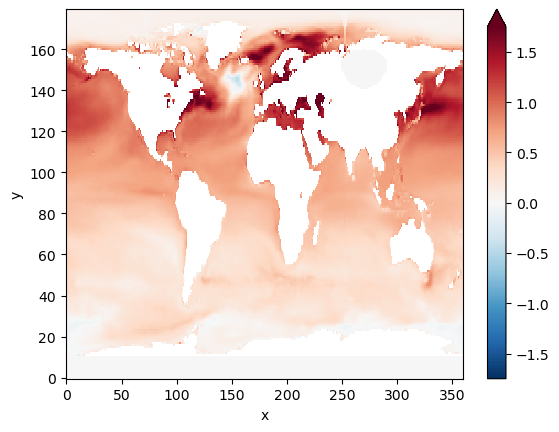

In [69]:
ds_merged_clean.mean('model').plot(vmax=1.75)

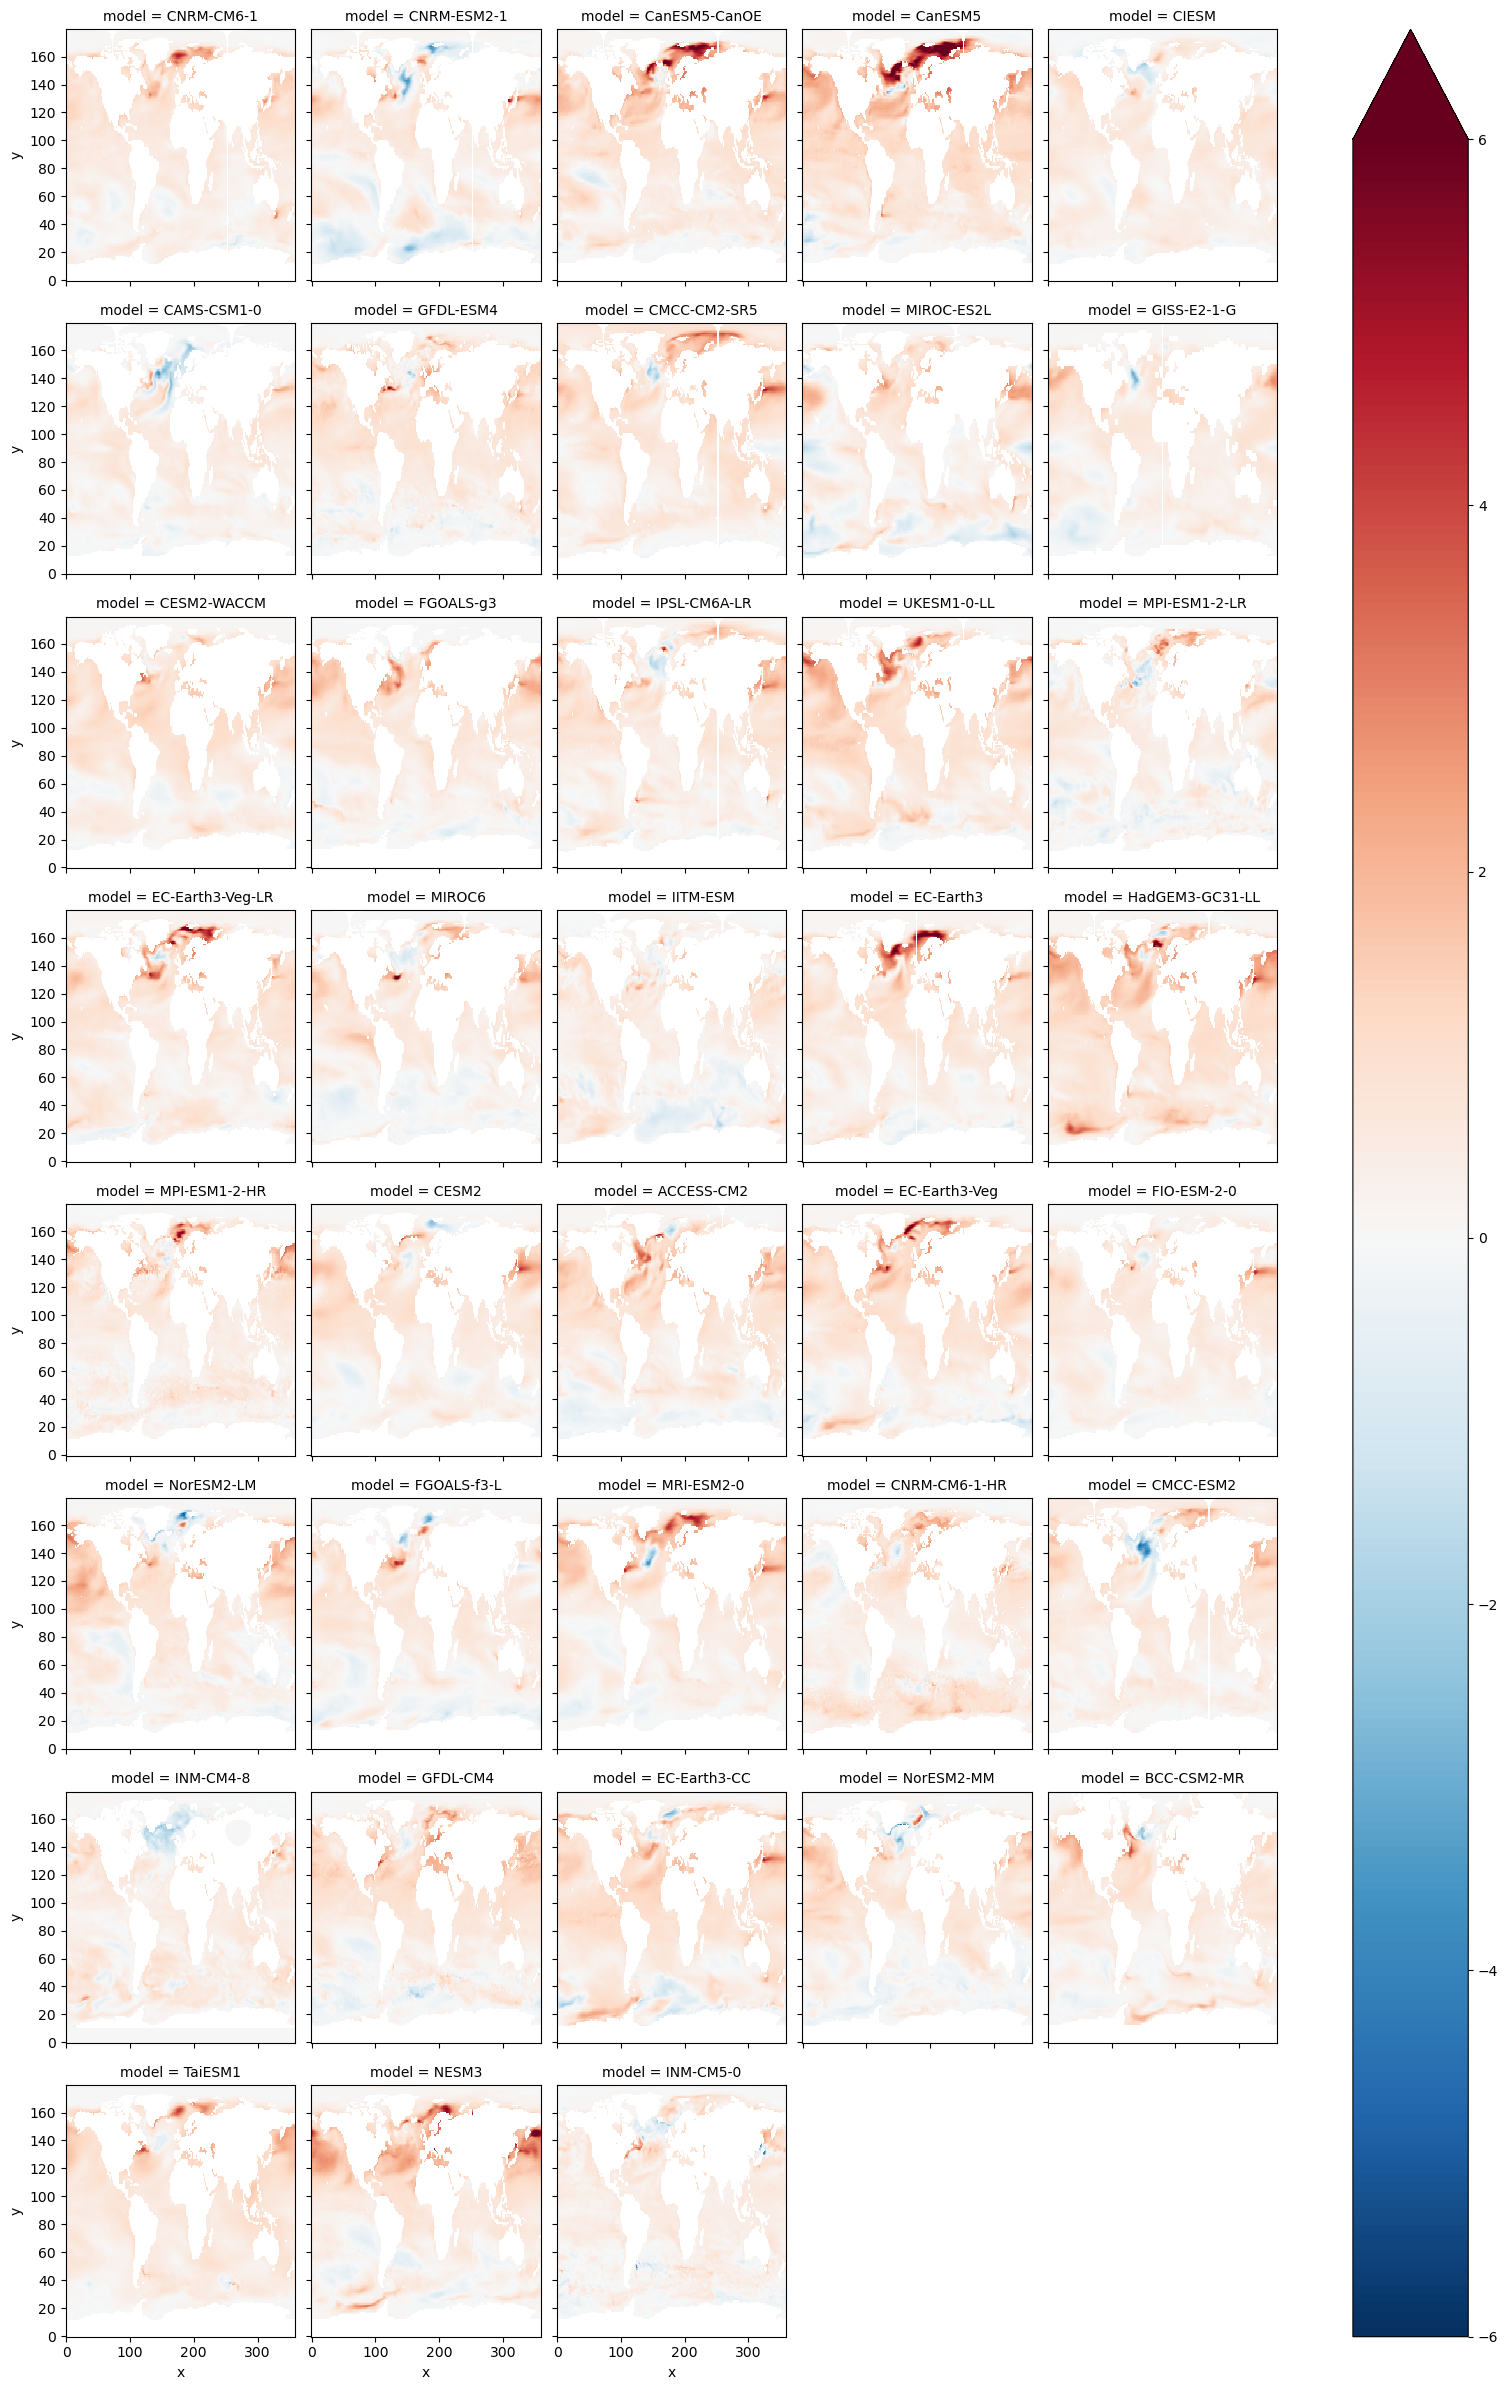

In [68]:
ds_merged_clean.plot(col='model', col_wrap=5, vmax=6)